# Usable UMIs Amount Estimation
To avoid sequencing and PCR errors, we use only UMIs with multiple duplicate reads. To determine a required sequencing depth (number of reads per cell), we would like to model the relationship between sequencing depth and number of UMIs present in given number of duplicates.

We use dataset obtained from mouse kidneys, sequenced by 10x sequencing.


In [1]:
from collections import Counter, OrderedDict, defaultdict
from dataclasses import dataclass
from itertools import chain
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysam
import scipy
from scipy import stats
from dataclasses_json import DataClassJsonMixin
from support_estimation.support import Support
from tqdm import tqdm

In [2]:
bam_files_data_folder = Path('/cellfile/datapublic/jkoubele/DR_dataset/AL4_old', desc='Processing .bam files')


@dataclass
class CellStatistics(DataClassJsonMixin):
    barcode: str
    num_reads: int
    duplicate_counter: dict[int, int]


@dataclass
class Dataset(DataClassJsonMixin):
    cells: list[CellStatistics]


run_processing_of_bam_files = False  # change to True to re-run the .bam files processing
if run_processing_of_bam_files:
    cells: list[CellStatistics] = []
    for file_path in tqdm(bam_files_data_folder.iterdir()):
        if file_path.suffix != '.bam':
            continue
        samfile = pysam.AlignmentFile(file_path, "rb")
        reads = [read for read in samfile if read.mapq >= 255 and
                 read.has_tag('UB') and
                 read.get_tag('UB') != '-' and
                 read.reference_name != 'chrM']
        umi_counter = Counter([read.get_tag('UB') for read in reads])
        cells.append(CellStatistics(barcode=file_path.stem,
                                    num_reads=len(reads),
                                    duplicate_counter=dict(Counter(umi_counter.values()))
                                    ))

    with open(f'./duplicate_counters_{bam_files_data_folder.stem}.json', 'w') as file_out:
        file_out.write(Dataset(cells=cells).to_json())


The median sequencing depth was 51k reads, and median number of UMIs was 22k.

We plot the histograms of reads per cell and also UMIs per cell:

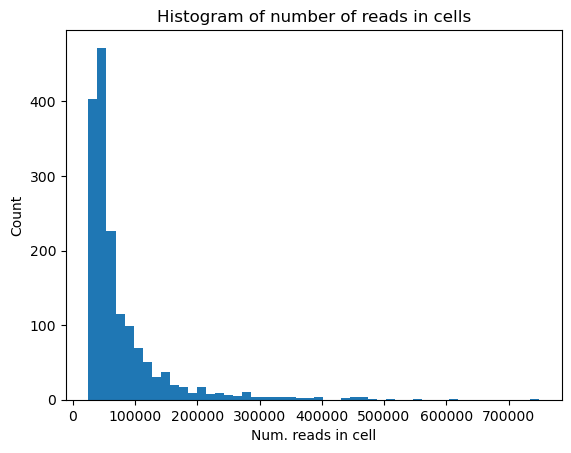

Descriptive statistics:
 count      1643.000000
mean      77017.091905
std       69638.623491
min       25043.000000
25%       39670.000000
50%       51759.000000
75%       84637.500000
max      749563.000000
dtype: float64


In [3]:
with open('./duplicate_counters_AL4_old.json') as input_file:
    dataset = Dataset.from_json(input_file.read())
    cells = dataset.cells

num_reads = [cell.num_reads for cell in cells]

plt.hist(num_reads, bins=50)
plt.xlabel('Num. reads in cell')
plt.ylabel('Count')
plt.title('Histogram of number of reads in cells')
plt.savefig('histogram_reads.png')
plt.show()

print("Descriptive statistics:\n", pd.Series(num_reads).describe())

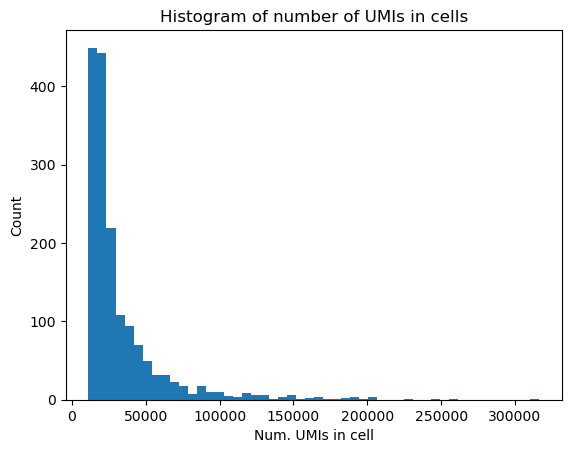

Descriptive statistics:
 count      1643.000000
mean      33016.648813
std       30093.251918
min       11162.000000
25%       16882.500000
50%       22057.000000
75%       36387.000000
max      316485.000000
dtype: float64


In [4]:
num_umis = [sum(cell.duplicate_counter.values()) for cell in cells]

plt.hist(num_umis, bins=50)
plt.xlabel('Num. UMIs in cell')
plt.ylabel('Count')
plt.title('Histogram of number of UMIs in cells')
plt.savefig('histogram_umis.png')
plt.show()

print("Descriptive statistics:\n", pd.Series(num_umis).describe())

Although cells somehow vary in the number of reads, the fraction of UMIs with a given number of duplicates is quite stable across the cells. E.g, most cells have about 40% of UMIs that have only 1 read, 25% of UMIs with 2 reads, etc.

This suggests that the differences in number of reads is driven primarily by cell size / mRNA content, and not by different capturing efficiency.

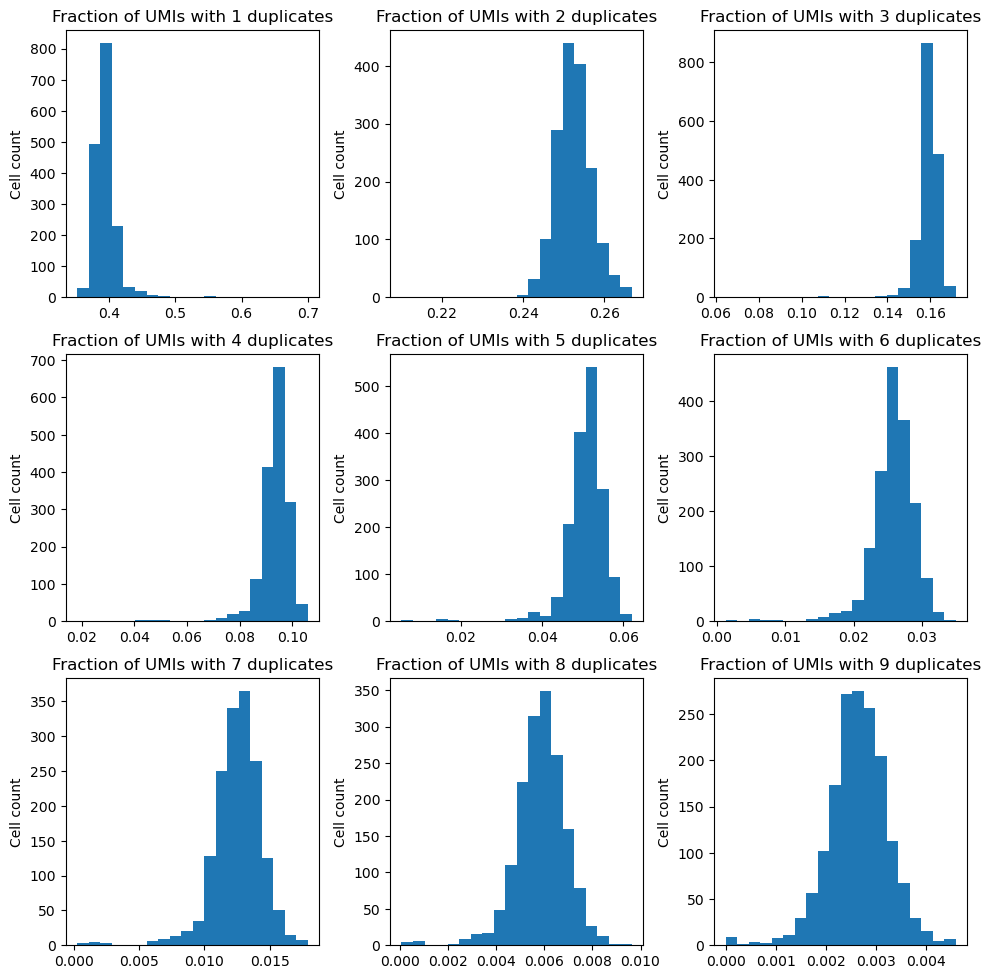

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
plt.tight_layout(pad=2)
for duplicate_number in range(1, 10):
    plt.subplot(3, 3, duplicate_number)
    plt.hist([(cell.duplicate_counter[duplicate_number] if duplicate_number in cell.duplicate_counter else 0)
              / sum(cell.duplicate_counter.values())
              for cell in cells], bins=20)
    plt.title(f'Fraction of UMIs with {duplicate_number} duplicates')
    plt.ylabel('Cell count')

plt.savefig('umi_fractions_per_duplicate.png')
plt.show()

We may therefore aggregate the reads from all cells together, to get a distribution of UMI duplicates in an average or median cell. 

As cells contain only negligible amount of UMIs that have more than 15 duplicates, we will omit them to simplify the analysis (and make plotting easier).

Average number of UMIs with more than 15 duplicates: 0.7395009129640913
Number of reads in average cell: 76999.92574558737
Number of UMIs in average cell: 33015.909312233714
Number of reads in median cell: 51873.0
Number of UMIs in median cell: 22102.0


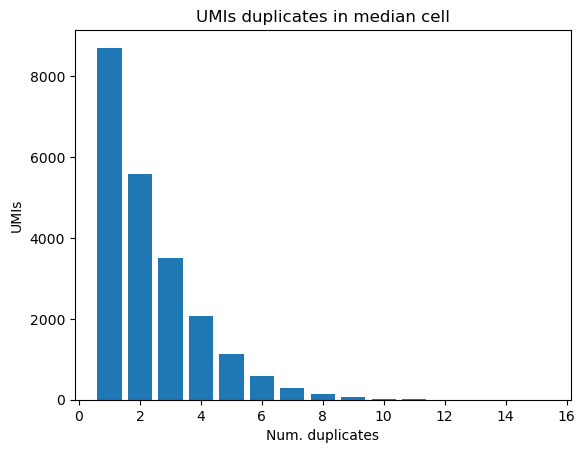

In [6]:
duplicate_numbers = set(chain.from_iterable([cell.duplicate_counter.keys() for cell in cells]))
average_cell_duplicate_counter = {duplicate_number:
                                      sum([cell.duplicate_counter[
                                               duplicate_number] if duplicate_number in cell.duplicate_counter else 0
                                           for cell in cells]) / len(cells)
                                  for duplicate_number in duplicate_numbers}
print(
    f"Average number of UMIs with more than 15 duplicates: {sum([value for key, value in average_cell_duplicate_counter.items() if key > 15])}")
average_cell_duplicate_counter = {key: value for key, value in average_cell_duplicate_counter.items() if key <= 15}
average_cell_duplicate_counter = OrderedDict(
    {key: average_cell_duplicate_counter[key] for key in sorted(average_cell_duplicate_counter.keys())})
print(f"Number of reads in average cell: {sum([key * value for key, value in average_cell_duplicate_counter.items()])}")
print(f"Number of UMIs in average cell: {sum(average_cell_duplicate_counter.values())}")

median_cell_duplicate_counter = OrderedDict({duplicate_number:
                                                 np.median([cell.duplicate_counter[
                                                                duplicate_number] if duplicate_number in cell.duplicate_counter else 0
                                                            for cell in cells])
                                             for duplicate_number in range(1, 16)})

median_cell_num_reads = sum([key * value for key, value in median_cell_duplicate_counter.items()])
median_cell_num_umis = sum(median_cell_duplicate_counter.values())
print(f"Number of reads in median cell: {median_cell_num_reads}")
print(f"Number of UMIs in median cell: {median_cell_num_umis}")

plt.bar(median_cell_duplicate_counter.keys(), height=median_cell_duplicate_counter.values())
plt.title('UMIs duplicates in median cell')
plt.ylabel('UMIs')
plt.xlabel('Num. duplicates')
plt.savefig('umi_duplicate_median_cell_histogram.png')
plt.show()

# Estimating the Number of Captured UMIs
We will use the method from paper [Chebyshev polynomials, moment matching, and optimal estimation of the unseen](https://projecteuclid.org/journals/annals-of-statistics/volume-47/issue-2/Chebyshev-polynomials-moment-matching-and-optimal-estimation-of-the-unseen/10.1214/17-AOS1665.full) to estimate the number of UMIs that were captured, but never sampled.

The method contain one parameter - $k$, the maximum plausible size of UMI pool. The method is assuming that the mimimum probability for UMI being sampled (if it's captured in the first place) is at least $\frac{1}{k}$. 

Fortunatelly, the estimated number of UMI pool size is relatively insensitive to the parameter $k$:

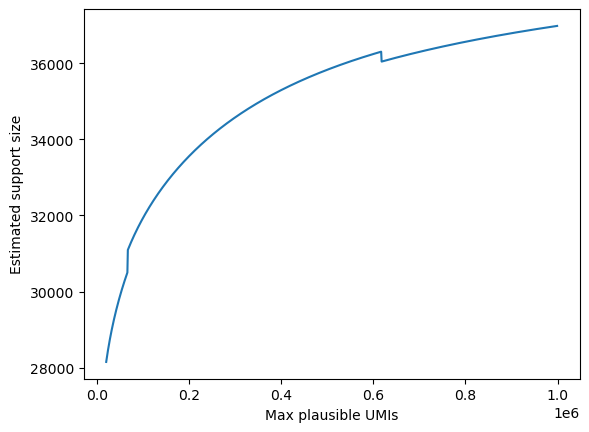

In [7]:
fingerprint = [[key, value] for key, value in median_cell_duplicate_counter.items() if value > 0 and key > 0]

k_values = np.arange(20_000, 1000_000, 1000)
estimated_support_sizes = [Support(pmin=1 / k).estimate(fingerprint) for k in k_values]
plt.plot(k_values, estimated_support_sizes)
plt.xlabel('Max plausible UMIs')
plt.ylabel('Estimated support size')
plt.savefig('estimated_support_size_vs_max_plausible_size.png')
plt.show()

In [8]:
print(Support(pmin=1 / 90_000).estimate(fingerprint) - median_cell_num_umis)
print(Support(pmin=1 / 360_000).estimate(fingerprint) - median_cell_num_umis)

9605.415207899281
12933.806394310937


We will set $k=2\times10^5$ as a maximum plausible number of captured UMIs. This leads to an estimate of support size equal to 33559, indicating that there is 11457 UMIs that were captured but never sampled during the sequencing.

estimated_support_size=33559


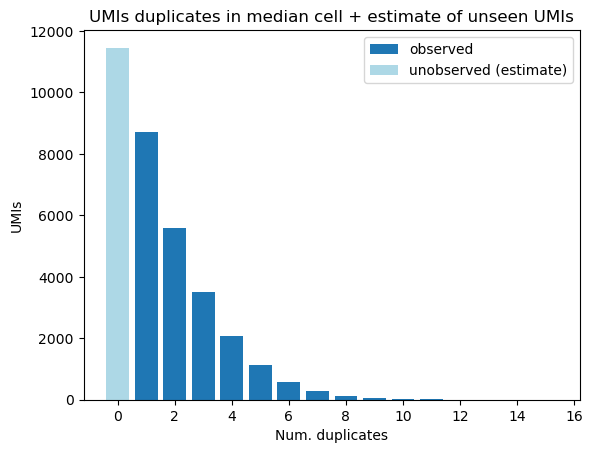

In [9]:
estimated_support_size = int(Support(pmin=1 / 200_000).estimate(fingerprint))
print(f"{estimated_support_size=}")
median_cell_duplicate_counter[0] = int(estimated_support_size - median_cell_num_umis)
sum(median_cell_duplicate_counter.values())
median_cell_duplicate_counter

plt.bar(median_cell_duplicate_counter.keys(), height=median_cell_duplicate_counter.values(), label='observed')
plt.bar(0, height=median_cell_duplicate_counter[0], color='lightblue', label='unobserved (estimate)')
plt.title('UMIs duplicates in median cell + estimate of unseen UMIs')
plt.ylabel('UMIs')
plt.xlabel('Num. duplicates')
plt.legend()
plt.savefig('umi_duplicate_with_unseen_estimate.png')
plt.show()

# Comparison to Other Distributions
We can observe that histogram of duplicates from uniform multinomal is practically identical to fitted binomial and fitted Poisson distribution.

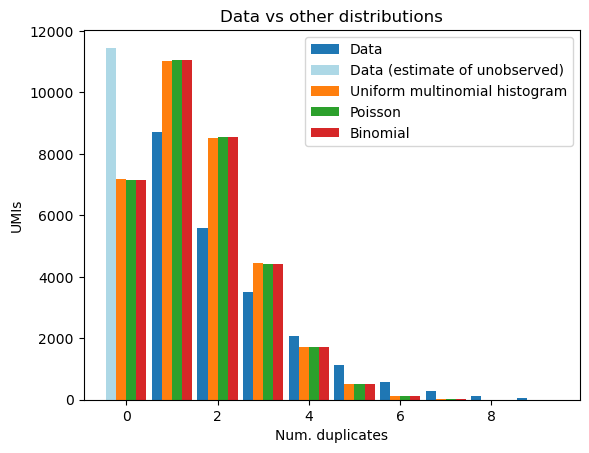

In [10]:
def estimate_uniform_multinomial_duplicate_histogram(n: int, k: int, num_replicates: int = 10) -> dict:
    multinomial_pmf = np.ones(int(k)) / k
    estimated_duplicates = defaultdict(int)
    for replicate in range(num_replicates):        
        sampled_counter = Counter(np.random.multinomial(n=n, pvals=multinomial_pmf))
        for key, value in sampled_counter.items():
            estimated_duplicates[key] += value
    return {key: value / num_replicates for key, value in estimated_duplicates.items() if value / num_replicates >= 1}

multinomial_duplicate_counter = estimate_uniform_multinomial_duplicate_histogram(n=median_cell_num_reads,
                                                                         k=estimated_support_size)

max_x_value_to_display = 10
x = np.asarray(sorted(list(set(median_cell_duplicate_counter) | set(multinomial_duplicate_counter))))
x = x[:max_x_value_to_display]

y_median_cell = [median_cell_duplicate_counter[x] if x in median_cell_duplicate_counter else 0 for x in x]
y_multinomial = np.asarray([multinomial_duplicate_counter[x] if x in multinomial_duplicate_counter else 0 for x in x])

poisson_rv = stats.poisson(median_cell_num_reads / estimated_support_size)
y_poisson = np.asarray([estimated_support_size * poisson_rv.pmf(x) for x in x])

binomial_rv = stats.binom(median_cell_num_reads, 1/ estimated_support_size)
y_binomial = np.asarray([estimated_support_size * binomial_rv.pmf(x) for x in x])


bar_width = 0.22
plt.bar(x=x - 3/2*bar_width, height=y_median_cell, width=bar_width, label='Data', color='tab:blue')
plt.bar(x=0 - 3/2*bar_width, height=y_median_cell[0], width=bar_width, label='Data (estimate of unobserved)',
        color='lightblue')
plt.bar(x=x - 1/2*bar_width, height=y_multinomial, width=bar_width, label='Uniform multinomial histogram', color='tab:orange')
plt.bar(x=x + 1/2 * bar_width, height=y_poisson, width=bar_width, label='Poisson', color='tab:green')
plt.bar(x=x + 3/2*bar_width, height=y_binomial, width=bar_width, label='Binomial', color='tab:red')
plt.legend()
plt.title('Data vs other distributions')
plt.xlabel('Num. duplicates')
plt.ylabel('UMIs')
plt.savefig('data_vs_other_distributions.png')
plt.show()

# Goodness of Fit
Compare the theoretical distributions (histogram of uniform multinomial, Poisson / Binomial) to the data.

In [11]:
# normalize Poisson, since we arbitralily cutted it at max_x_value_to_display = 10
# (Poisson's support is whole N so some cut is necessary anyway)

y_poisson *= sum(y_median_cell) / sum(y_poisson)

godness_of_fit_chi_square  = stats.chisquare(f_obs=y_median_cell, f_exp=y_poisson)
print(f"{godness_of_fit_chi_square.pvalue=}")

godness_of_fit_chi_square.pvalue=0.0


# Dirichlet-multinomial estimation
We will estimate the parameter $\alpha$ of Dirichlet-multinomial distribution (see Redmine for more details).

best_alpha=1.6500000000000001


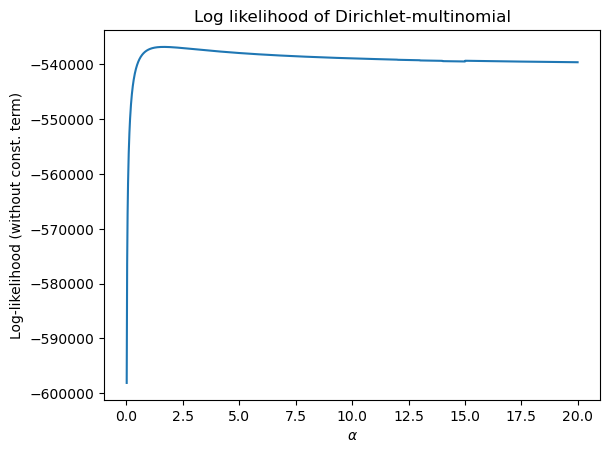

In [12]:
def log_gamma_stirling(x: float) -> float:
    # Uses Stirling approximation for larger value of x
    return np.log(scipy.special.gamma(x)) if x <= 15 else np.log(np.sqrt(2 * np.pi * (x - 1))) + (x - 1) * np.log(
        (x - 1) / np.e)


def ll_dirichlet_multinomial(duplicate_counter: dict, alpha: float) -> float:
    k = sum(duplicate_counter.values())
    n = sum([key * value for key, value in duplicate_counter.items()])
    ll = log_gamma_stirling(alpha * k) - log_gamma_stirling(n + alpha * k) - k * log_gamma_stirling(alpha)
    for key, value in duplicate_counter.items():
        ll += value * log_gamma_stirling(key + alpha)
    return ll


alphas = np.arange(0.01, 20, 0.01)
log_likelihoods = [ll_dirichlet_multinomial(median_cell_duplicate_counter, alpha) for alpha in alphas]

best_alpha = alphas[np.argmax(log_likelihoods)]
print(f"{best_alpha=}")

plt.plot(alphas, log_likelihoods)
plt.xlabel(r"$\alpha$")
plt.ylabel('Log-likelihood (without const. term)')
plt.title("Log likelihood of Dirichlet-multinomial")
plt.savefig('log_likelihood_dirichlet_multinomial.png')
plt.show()

Given the estimated values of $k$ and $\alpha$, we may model sequencing of varying depth $n$ simply by sampling from corresponding Dirichlet-multinomial distribution and aggregating the results over several such samples. When estimating the histogram of duplicates for the $n=51873$ (corresponding to the training data), we obtain a reasonably looking fit of the model:

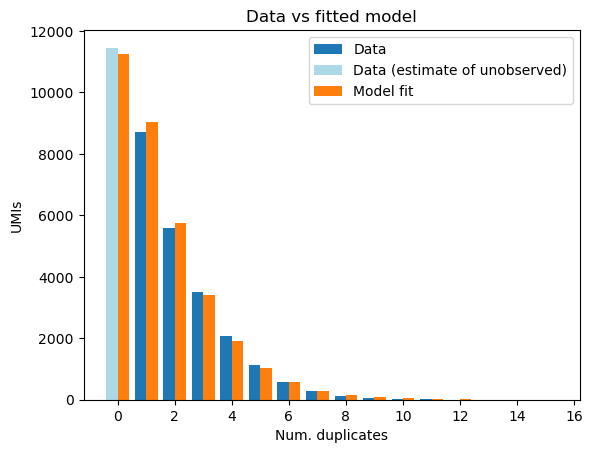

In [13]:
def estimate_dirichlet_multinomial_duplicate_histogram(n: int, k: int = 33_559, alpha: float = 1.65, num_replicates: int = 10) -> dict:
    estimated_duplicates = defaultdict(int)
    for replicate in range(num_replicates):
        p = np.random.dirichlet(alpha * np.ones(k))
        sampled_counter = Counter(np.random.multinomial(n=n, pvals=p))
        for key, value in sampled_counter.items():
            estimated_duplicates[key] += value
    return {key: value / num_replicates for key, value in estimated_duplicates.items() if value / num_replicates >= 1}


estimated_histogram = estimate_dirichlet_multinomial_duplicate_histogram(median_cell_num_reads)

x = np.asarray(sorted(list(set(median_cell_duplicate_counter) | set(estimated_histogram))))
y_duplicate = [median_cell_duplicate_counter[x] if x in median_cell_duplicate_counter else 0 for x in x]
y_sampled = [estimated_histogram[x] if x in estimated_histogram else 0 for x in x]

bar_width = 0.4
plt.bar(x=x - bar_width / 2, height=y_duplicate, width=bar_width, label='Data', color='tab:blue')
plt.bar(x=0 - bar_width / 2, height=y_duplicate[0], width=bar_width, label='Data (estimate of unobserved)',
        color='lightblue')
plt.bar(x=x + bar_width / 2, height=y_sampled, width=bar_width, label='Model fit', color='tab:orange')
plt.legend()
plt.title('Data vs fitted model')
plt.xlabel('Num. duplicates')
plt.ylabel('UMIs')
plt.savefig('data_vs_model_fit.png')
plt.show()

# Comparison of All Distributions

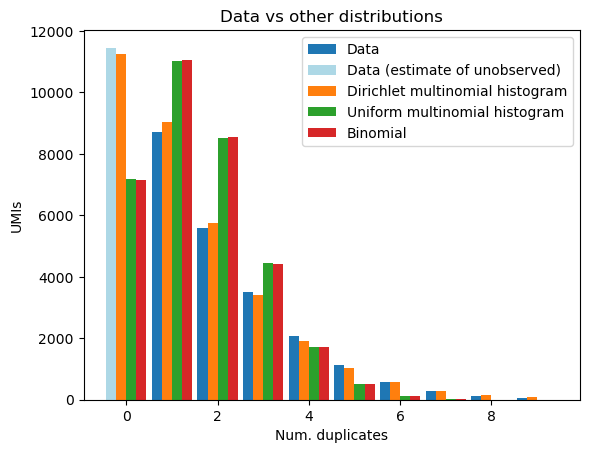

In [14]:
x = np.arange(max_x_value_to_display)
y_dirichlet_multinomial = [estimated_histogram[x] if x in estimated_histogram else 0 for x in x]

bar_width = 0.22
plt.bar(x=x - 3/2*bar_width, height=y_median_cell, width=bar_width, label='Data', color='tab:blue')
plt.bar(x=0 - 3/2*bar_width, height=y_median_cell[0], width=bar_width, label='Data (estimate of unobserved)',
        color='lightblue')
plt.bar(x=x - 1/2 * bar_width, height=y_dirichlet_multinomial, width=bar_width, label='Dirichlet multinomial histogram', color='tab:orange')
plt.bar(x=x + 1/2*bar_width, height=y_multinomial, width=bar_width, label='Uniform multinomial histogram', color='tab:green')
plt.bar(x=x + 3/2*bar_width, height=y_binomial, width=bar_width, label='Binomial', color='tab:red')

plt.legend()
plt.title('Data vs other distributions')
plt.xlabel('Num. duplicates')
plt.ylabel('UMIs')
plt.savefig('data_vs_all_other_distributions.png')
plt.show()

We may use the model to predict the histogram of duplicates for different sequencing depth, e.g, $n=150,000$:

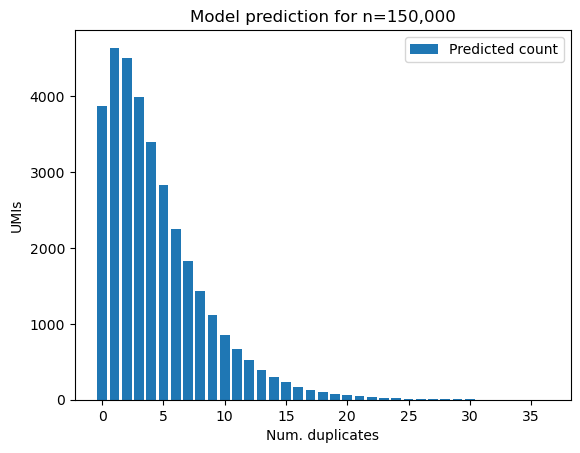

In [15]:
estimated_histogram = estimate_dirichlet_multinomial_duplicate_histogram(n=150_000)

plt.bar(estimated_histogram.keys(), height=estimated_histogram.values(), label='Predicted count')
plt.title('Model prediction for n=150,000')
plt.ylabel('UMIs')
plt.xlabel('Num. duplicates')
plt.legend()
plt.savefig('histogram_prediction_150k.png')
plt.show()

Given the model, we may also predict any statistic derived from the histogram. For example, if we would only use UMIs with at least 5 duplicate reads, we may predict the amount of such UMIs for different sequencing depths:

Estimating UMIs with enough duplicates: 100%|███| 98/98 [00:05<00:00, 17.43it/s]


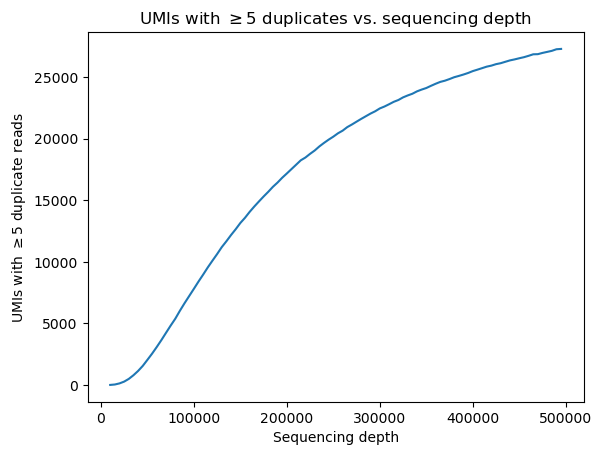

In [16]:
depths = np.arange(10_000, 500_000, 5000)
umis_with_enough_duplicates = []
duplicate_threshold = 5
for n in tqdm(depths, desc='Estimating UMIs with enough duplicates'):
    estimated_histogram = estimate_dirichlet_multinomial_duplicate_histogram(n)
    umis_with_enough_duplicates.append(sum([value for key, value in estimated_histogram.items() if 
                                            key >= duplicate_threshold]))

plt.plot(depths, umis_with_enough_duplicates)
plt.xlabel('Sequencing depth')
plt.ylabel(fr'UMIs with $\geq {duplicate_threshold}$ duplicate reads')
plt.title(fr'UMIs with $\geq {duplicate_threshold}$ duplicates vs. sequencing depth')
plt.savefig('umis_with_enough_duplicates_vs_depth.png')
plt.show()


If we assume that the cost of sequencing is linear in the number of reads (and does not depend directly on the number of cells being sequenced), we may want to select a sequencing depth that maximizes ratio of UMIs with enough duplicates to reads:

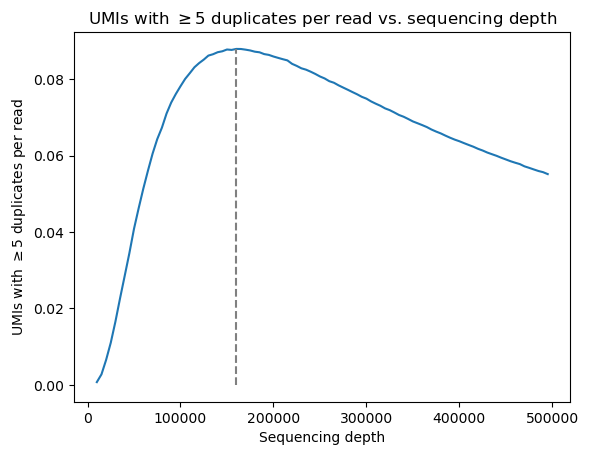

optimal_sequencing_depth=160000


In [17]:
optimal_sequencing_depth = depths[np.argmax(umis_with_enough_duplicates / depths)]

plt.plot(depths, umis_with_enough_duplicates / depths)
plt.xlabel('Sequencing depth')
plt.ylabel(fr'UMIs with $\geq {duplicate_threshold}$ duplicates per read')
plt.title(fr'UMIs with $\geq {duplicate_threshold}$ duplicates per read vs. sequencing depth')
plt.vlines(x=optimal_sequencing_depth, ymin=0, ymax=np.max(umis_with_enough_duplicates / depths), 
           color = 'grey', ls= 'dashed')
plt.savefig('umis_with_enough_duplicates_per_read_vs_depth.png')
plt.show()

print(f"{optimal_sequencing_depth=}")